# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

In [5]:
def on_iteration(iteration_count, x, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("iteration", iteration_count, info, J_opt, dynamics.reduce_state(x))

In [6]:
dt = 0.01
dynamics = InvertedPendulumDynamics(dt)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0]))

Q = np.array([[100.0, 0.0, 0.0], [0.0, 100.0, 0.0], [0.0, 0.0, 1.0]])
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[1.0]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
T = 600
x0 = dynamics.augment_state(np.array([np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (T, dynamics.action_size))
ilqr = iLQR(dynamics, cost, T)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

iteration 0 accepted 139842.812452 [ 0.81036514 -0.10622134]
iteration 1 accepted 128587.279821 [-0.85469196 -3.76281896]
iteration 2 accepted 122120.413378 [-0.79701299 -3.91969462]
iteration 3 accepted 101726.946355 [-0.38103165 -2.45268178]
iteration 4 accepted 93508.8841836 [-0.23815872 -0.44916787]
iteration 5 accepted 74844.9474883 [-0.00324172  0.31788421]
iteration 6 accepted 73016.951464 [-0.03643132  0.16164354]
iteration 7 accepted 71775.1287588 [-0.02575819  0.08557726]
iteration 8 accepted 71207.1929411 [-0.02420405  0.07760467]
iteration 9 accepted 67962.4791082 [ 0.01436718  0.0517308 ]
iteration 10 accepted 67442.7281028 [-0.03094273  0.07063079]
iteration 11 accepted 66366.3469427 [ 0.01429113  0.04896845]
iteration 12 accepted 65124.4143239 [-0.01413889  0.00790346]
iteration 13 accepted 64775.0298657 [-0.01541976  0.02681864]
iteration 14 accepted 64764.5933356 [-0.01467358  0.04017728]
iteration 15 accepted 64472.3736902 [-0.00481249  0.05488761]
iteration 16 accept

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(T) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

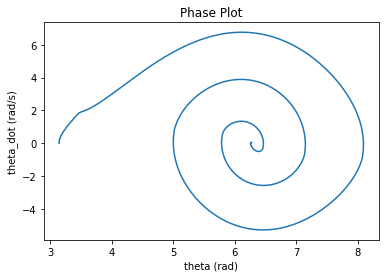

In [12]:
plt.plot(theta, theta_dot)
plt.xlabel("theta (rad)")
plt.ylabel("theta_dot (rad/s)")
plt.title("Phase Plot")

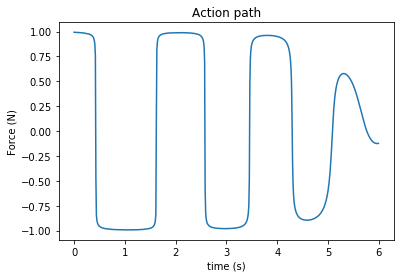

In [13]:
plt.plot(t, us)
plt.xlabel("time (s)")
plt.ylabel("Force (N)")
plt.title("Action path")

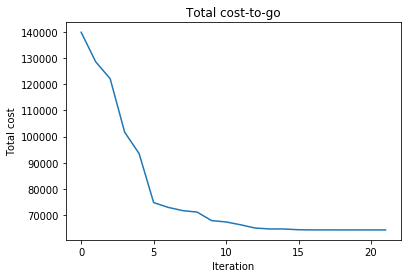

In [14]:
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("Total cost")
plt.title("Total cost-to-go")